# Braves Assessment 
## Curveball Swing and Miss
## Scott Matsubara
## 11/15/2023

In [193]:
import pandas as pd

import numpy as np
# ! pip install openpyxl
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import recall_score

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [194]:
data = pd.read_csv("PitchData.csv")
data.shape

(24128, 24)

In [195]:
data.head()

,Pitcher_ID,Pitcher,Pitcher_Throws,Batter_ID,Batter,Batter_Hits,Game_Date,Top_Bot,Inning,Balls,Strikes,Outs,Pitch_Outcome,Pitch_Type,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
0,493247,"Moylan, Peter",R,408314,"Reyes, Jose",L,4/19/2018,1,9,1.0,0.0,1.0,StrikeSwinging,ChangeUp,84.906693,-11.465343,-0.838458,3490.955811,274.452423,3.923955,4.430658,5.586043,0.686267,1.161676
1,493247,"Moylan, Peter",R,408314,"Reyes, Jose",L,4/19/2018,1,9,1.0,1.0,1.0,InPlay,Fastball,90.294609,-11.647513,-2.098279,2136.909912,279.762299,4.008803,4.276614,5.146793,0.097627,2.259780
2,493247,"Moylan, Peter",R,408314,"Reyes, Jose",L,4/19/2018,1,9,0.0,0.0,1.0,BallCalled,Fastball,89.237747,-11.620699,-1.329038,2156.246338,274.931854,4.252917,4.254495,5.265786,2.074740,2.441108
3,493247,"Moylan, Peter",R,425877,"Molina, Yadier",R,6/29/2018,2,7,0.0,0.0,0.0,StrikeCalled,Fastball,90.570641,-9.241369,-0.773936,1960.123047,273.865662,4.286363,4.362812,5.690596,-0.023817,2.317372
4,493247,"Moylan, Peter",R,425877,"Molina, Yadier",R,6/29/2018,2,7,0.0,1.0,0.0,InPlay,Fastball,90.648163,-8.978740,-2.086365,2039.517578,282.916443,4.201683,4.236205,5.409224,-0.184216,2.387354


# 1. Data Cleaning

In [196]:
def get_missing_val_columns(data):
    # Check for missing values in each column
    missing_values = data.isnull().sum()

    # Display columns with missing values (if any)
    return missing_values[missing_values > 0]

get_missing_val_columns(data)

Balls                21
Strikes              21
Outs                 21
release_spin_rate    18
dtype: int64

In [197]:
data[data.Outs.isna()].Pitch_Type.unique()

array(['Slider', 'ChangeUp', 'Fastball', 'Cutter'], dtype=object)

### Since none of the columns that contain missing values for balls, strikes, outs are curveballs, we can remove them from our data.

In [198]:
data_clean = data.dropna(subset = ['Outs'])

In [199]:
get_missing_val_columns(data_clean)

release_spin_rate    18
dtype: int64

In [200]:
data_clean[data_clean.release_spin_rate.isna()].head()

,Pitcher_ID,Pitcher,Pitcher_Throws,Batter_ID,Batter,Batter_Hits,Game_Date,Top_Bot,Inning,Balls,Strikes,Outs,Pitch_Outcome,Pitch_Type,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
1004,527055,"Vizcaino, Arodys",R,592178,"Bryant, Kris",R,5/15/2018,1,9,1.0,2.0,2.0,StrikeSwinging,Slider,85.347832,2.171271,0.604236,NaN,98.362701,0.922411,5.880696,5.664829,-1.432511,2.004086
2025,542432,"Ramirez, Jose",R,501213,"Sierra, Moises",R,4/11/2018,2,10,1.0,0.0,1.0,StrikeCalled,Fastball,95.956230,-9.756713,8.200313,NaN,227.385406,2.432273,5.573578,5.742480,-1.032813,2.123867
3956,592314,"Foltynewicz, Mike",R,594988,"Schebler, Scott",L,6/25/2018,1,3,0.0,2.0,0.0,InPlay,Curveball,76.522697,2.161296,-2.544355,NaN,41.025692,1.859652,6.127648,5.050128,0.845152,1.077894
4221,592314,"Foltynewicz, Mike",R,543768,"Shaw, Travis",L,7/6/2018,2,5,1.0,0.0,2.0,FoulBall,Fastball,97.032921,-6.369360,8.404684,NaN,214.629211,2.370480,5.733621,6.005318,0.680549,3.456828
4588,592314,"Foltynewicz, Mike",R,544931,"Strasburg, Stephen",R,4/10/2018,2,4,2.0,2.0,2.0,BallCalled,Curveball,82.446323,4.033463,-3.661060,NaN,48.441750,2.046416,6.114498,5.911280,-0.324396,0.826791


### Lets replace missing spin rate values with the average based on pitch type and pitcher

In [201]:
data_clean['release_spin_rate'] = data_clean.groupby(['Pitcher','Pitch_Type'])['release_spin_rate'].transform(lambda x: x.fillna(x.mean()))


In [202]:
get_missing_val_columns(data_clean)

Series([], dtype: int64)

### Next lets look for outliers in the data

In [203]:
data_clean.describe()

,Pitcher_ID,Batter_ID,Top_Bot,Inning,Balls,Strikes,Outs,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
count,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000,24107.000000
mean,569324.226366,552781.556063,1.492388,5.054051,0.908865,0.883436,0.985274,88.845926,-1.459579,4.591977,2191.089748,183.493441,0.695144,5.836909,5.829528,-0.008632,2.245176
std,72373.687302,66520.949957,0.499952,2.710824,0.978674,0.823825,0.810098,7.270236,5.518372,5.120492,478.284769,68.892429,1.924563,0.619669,0.509501,0.892883,0.952896
min,434671.000000,400284.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-14.466215,-13.557931,0.000000,0.000000,-3.089811,0.000000,0.000000,-3.947303,-2.266628
25%,527054.000000,502110.000000,1.000000,3.000000,0.000000,0.000000,0.000000,85.075691,-6.320160,1.483524,2102.891968,146.497276,-1.615295,5.467358,5.543336,-0.619745,1.630685
50%,592314.000000,571448.000000,1.000000,5.000000,1.000000,1.000000,1.000000,90.382256,-1.505716,6.040208,2270.084473,193.445175,1.679879,5.927446,5.886992,-0.008082,2.245231
75%,621345.000000,605141.000000,2.000000,7.000000,2.000000,2.000000,2.000000,93.802090,3.228437,8.562909,2454.125488,226.177544,2.169291,6.274387,6.146020,0.590537,2.864316
max,669060.000000,670950.000000,2.000000,15.000000,3.000000,2.000000,2.000000,146.931191,11.857052,13.357627,3496.190674,359.796051,4.625762,7.106002,7.623008,9.670856,7.496172


### Release speed cannot be over 106 mph any pitch listed as greater than 106 can be considered an incorrectly tracked pitch. We would like to remove any of these pitches because we likely cannot trust the rest of the pitch readings

In [204]:
data_clean[data_clean.release_speed>106]

,Pitcher_ID,Pitcher,Pitcher_Throws,Batter_ID,Batter,Batter_Hits,Game_Date,Top_Bot,Inning,Balls,Strikes,Outs,Pitch_Outcome,Pitch_Type,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
22992,595032,"Whitley, Chase",R,467793,"Santana, Carlos",L,4/27/2018,2,7,1.0,0.0,2.0,BallCalled,Fastball,146.931191,-3.428378,10.260417,2049.720947,195.746750,0.992806,6.398058,5.900261,-0.946403,2.345998
22994,595032,"Whitley, Chase",R,595751,"Alfaro, Jorge",R,4/27/2018,2,7,1.0,1.0,0.0,StrikeCalled,Fastball,137.843979,-4.474815,8.831584,2109.343750,207.553223,1.171515,6.323643,5.927411,0.974264,2.070384
23004,595032,"Whitley, Chase",R,546318,"Herrera, Odubel",L,4/27/2018,2,7,1.0,0.0,2.0,StrikeCalled,Fastball,126.139870,-2.671131,9.999738,2052.152832,194.271195,1.009303,6.335471,5.949590,0.487811,2.662500


### Unless Chase Whitley is simply the best pitcher to ever live but the MLB wants to keep him a secret, these 3 pitches by him are incorrectly tracked and we would like to remove these pitches

### Also found that all pitches with speeds less than 60 have 0 for many pitch characteristics, so we would like to remove these as well

### Any pitch below 60 mph is likely a position pitcher pitching and would not be useful for our analysis

In [205]:
data_clean[(data_clean.release_speed<60)].head()

,Pitcher_ID,Pitcher,Pitcher_Throws,Batter_ID,Batter,Batter_Hits,Game_Date,Top_Bot,Inning,Balls,Strikes,Outs,Pitch_Outcome,Pitch_Type,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
91,493247,"Moylan, Peter",R,514917,"Hernandez, Cesar",L,4/29/2018,2,7,2.0,2.0,2.0,BallCalled,ChangeUp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,493247,"Moylan, Peter",R,514917,"Hernandez, Cesar",L,4/29/2018,2,7,3.0,2.0,2.0,BallCalled,Slider,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231,493247,"Moylan, Peter",R,596748,"Franco, Maikel",R,4/29/2018,2,6,0.0,0.0,1.0,FoulBall,Fastball,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
233,493247,"Moylan, Peter",R,596748,"Franco, Maikel",R,4/29/2018,2,6,0.0,1.0,1.0,InPlay,Fastball,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,493247,"Moylan, Peter",R,606299,"Peraza, Jose",R,4/23/2018,2,6,1.0,0.0,2.0,InPlay,Undefined,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
data_clean[(data_clean.release_speed<60) & (data_clean.release_speed>0)]

,Pitcher_ID,Pitcher,Pitcher_Throws,Batter_ID,Batter,Batter_Hits,Game_Date,Top_Bot,Inning,Balls,Strikes,Outs,Pitch_Outcome,Pitch_Type,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
4203,592314,"Foltynewicz, Mike",R,518934,"LeMahieu, DJ",R,8/18/2018,1,3,0.0,0.0,2.0,BallCalled,Curveball,51.307163,5.780713,-1.67991,896.574097,111.887466,1.916908,5.511898,5.877824,9.670856,5.376357


In [207]:
data_clean = data_clean[(data_clean.release_speed>60) & (data_clean.release_speed<106)]

### Spin Rate Cannot be 0 so lets remove instances where this occurs and any instances where this occurs

In [208]:
data_clean[data_clean.release_spin_rate==0].head()

,Pitcher_ID,Pitcher,Pitcher_Throws,Batter_ID,Batter,Batter_Hits,Game_Date,Top_Bot,Inning,Balls,Strikes,Outs,Pitch_Outcome,Pitch_Type,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z
193,493247,"Moylan, Peter",R,572191,"Taylor, Michael A.",R,4/2/2018,1,5,1.0,2.0,1.0,FoulBall,Slider,78.171318,4.104160,-1.239213,0.0,80.544319,3.948359,4.262581,5.339577,-0.190321,1.513076
195,493247,"Moylan, Peter",R,572191,"Taylor, Michael A.",R,4/2/2018,1,5,1.0,2.0,1.0,StrikeSwinging,Slider,79.686630,4.125795,-1.018607,0.0,82.694984,4.029811,4.258097,5.686356,-1.497728,1.459603
248,493247,"Moylan, Peter",R,600474,"Severino, Pedro",R,4/2/2018,1,5,0.0,2.0,2.0,InPlay,Slider,78.386612,4.357222,-2.446258,0.0,69.317398,4.038105,4.428456,5.325463,-0.301959,1.565964
378,493247,"Moylan, Peter",R,581527,"Travis, Devon",R,6/19/2018,2,6,0.0,0.0,1.0,BallCalled,Slider,76.323181,3.667664,-2.350725,0.0,71.360451,4.369768,4.141690,5.291473,-1.788506,1.432930
507,493247,"Moylan, Peter",R,656555,"Hoskins, Rhys",R,3/30/2018,1,8,0.0,1.0,0.0,StrikeCalled,Slider,77.015205,3.962322,-0.918014,0.0,88.342216,3.989779,4.160677,4.712274,0.212132,2.400961


In [209]:
data_clean = data_clean[data_clean.release_spin_rate>0]

# 2. Feature Engineering

### Adjust plate_x by batter handedness so a negative value means an inside pitch and a postive value means an outside pitch

In [210]:
def pitch_category(row):
    if (row['Batter_Hits'] == "L"):
        return row['plate_x'] * -1.0
    else:
        return row['plate_x']
        
data_clean['plate_x'] = data_clean.apply(pitch_category,axis=1)

### Create response variable that tells if a swing and miss occured.

In [211]:
data_clean.Pitch_Outcome.unique()

array(['StrikeSwinging', 'InPlay', 'BallCalled', 'StrikeCalled',
       'FoulBall', 'HitByPitch', 'Undefined'], dtype=object)

In [212]:
data_clean['SwingAndMiss'] = data_clean.Pitch_Outcome.apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

### Create a new variable that is the value of the previous pitch. Curveballs should tunnel well off of fastballs and usually would not do well when thrown after a changeup

In [213]:
data_clean['Previous_Pitch'] = data_clean['Pitch_Type'].shift(1).where((data_clean['Batter'] == data_clean['Batter'].shift(1)) & (data['Batter'] == data['Batter'].shift(1)))
data_clean['Previous_Pitch'] = data_clean['Previous_Pitch'].fillna("First Pitch")

### Create a new categorical variable that is the type of count

In [214]:
def pitch_category(row):
    if ((row['Balls'] == 3) and (row['Strikes'] == 2)):
        return "Full"
    elif (((row['Balls'] == 2) and (row['Strikes'] == 0)) or ((row['Balls'] == 3) and (row['Strikes'] == 0)) or ((row['Balls'] == 3) and (row['Strikes'] == 1))) :
        return "Behind"
    elif (((row['Balls'] == 0) and (row['Strikes'] == 2)) or ((row['Balls'] == 1) and (row['Strikes'] == 2)) or ((row['Balls'] == 2) and (row['Strikes'] == 2))):
        return "2-Strikes"
    else:
        return "Neutral"

data_clean['Pitch_Category'] = data_clean.apply(pitch_category,axis=1)

### Get only data for curveballs

In [215]:
data_CB = data_clean[data_clean.Pitch_Type=="Curveball"]

In [216]:
data_CB.describe()

,Pitcher_ID,Batter_ID,Top_Bot,Inning,Balls,Strikes,Outs,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,SwingAndMiss
count,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000
mean,576729.991429,554447.016735,1.457551,5.022857,0.619592,0.890612,1.008980,78.152949,0.671852,-5.783067,2586.447768,164.994796,0.152496,6.078222,5.499905,-0.276310,2.004431,0.114694
std,76654.426859,66993.501130,0.498297,2.558959,0.826140,0.856051,0.813775,3.330634,5.207721,3.503091,223.697565,134.645311,1.878846,0.497826,0.489161,0.898169,1.079493,0.318717
min,434671.000000,408236.000000,1.000000,1.000000,0.000000,0.000000,0.000000,66.346397,-10.445124,-13.557931,1093.559326,1.334717,-2.729507,4.212477,3.563736,-3.947303,-1.877515,0.000000
25%,527054.000000,502671.000000,1.000000,3.000000,0.000000,0.000000,0.000000,76.057501,-4.550367,-8.789668,2494.781678,47.857426,-1.972835,5.833561,5.123536,-0.874625,1.313594,0.000000
50%,592314.000000,571466.000000,1.000000,5.000000,0.000000,1.000000,1.000000,78.135125,1.951324,-5.889831,2610.684204,73.942570,1.243083,6.087559,5.517852,-0.279234,1.995063,0.000000
75%,656794.000000,605412.000000,2.000000,7.000000,1.000000,2.000000,2.000000,80.639137,5.419935,-2.803432,2715.194336,324.298760,1.857554,6.520100,5.827918,0.316541,2.677439,0.000000
max,663465.000000,665742.000000,2.000000,14.000000,3.000000,2.000000,2.000000,88.467682,10.995934,4.621639,3145.458496,359.658966,4.272127,6.938879,7.296431,2.977174,7.496172,1.000000


In [217]:
data_CB.SwingAndMiss.value_counts()

0    2169
1     281
Name: SwingAndMiss, dtype: int64

### We can see the dataset, so we would like to make sure to include a balanced amount of 0 and 1 response values in the training and testing dataset

# 3. Modeling

In [218]:
data_CB.columns

Index(['Pitcher_ID', 'Pitcher', 'Pitcher_Throws', 'Batter_ID', 'Batter',
       'Batter_Hits', 'Game_Date', 'Top_Bot', 'Inning', 'Balls', 'Strikes',
       'Outs', 'Pitch_Outcome', 'Pitch_Type', 'release_speed', 'x_movement',
       'z_movement', 'release_spin_rate', 'spin_dir', 'release_pos_x',
       'release_pos_z', 'release_extension', 'plate_x', 'plate_z',
       'SwingAndMiss', 'Previous_Pitch', 'Pitch_Category'],
      dtype='object')

### Create X and y data for modeling and split into training and testing while making sure to stratify y so there are the same ratio of response classes in the train and test data

In [219]:
X = data_CB.drop(columns = ['Pitcher_ID','Pitcher','Batter_ID','Batter','Batter_Hits', 'Game_Date', 'Top_Bot', 'Inning', 'Balls', 'Strikes','Pitch_Outcome','Pitch_Type','SwingAndMiss'])
y = data_CB['SwingAndMiss'] 

In [220]:
# change outs to a categorical variable
X['Outs'] = X['Outs'].astype(str)

categorical_columns = ['Pitcher_Throws', 'Previous_Pitch', 'Pitch_Category','Outs']
non_categorical_columns = [col for col in X.columns if col not in categorical_columns]

X_cat = X[categorical_columns]
X_num = X.drop(columns=categorical_columns).reset_index()

# One Hot Encode teh
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to remove the first category to avoid multicollinearity
df_onehot = pd.DataFrame(encoder.fit_transform(X_cat), columns=encoder.get_feature_names_out(X_cat.columns))

X_encoded = pd.concat([X_num, df_onehot], axis=1)
X_encoded = X_encoded.drop(columns = ['index'])

### Create an X that is Standardized

In [221]:
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X_num)
X_numerical_scaled = pd.DataFrame(X_numerical_scaled,columns = X_num.columns)

X_encoded_scaled = pd.concat([X_numerical_scaled, df_onehot], axis=1).drop(columns = ['index'])
X_encoded_scaled.head()

,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,Pitcher_Throws_R,Previous_Pitch_Curveball,Previous_Pitch_Cutter,Previous_Pitch_Fastball,Previous_Pitch_First Pitch,Previous_Pitch_Slider,Pitch_Category_Behind,Pitch_Category_Full,Pitch_Category_Neutral,Outs_1.0,Outs_2.0
0,0.198509,0.806521,1.557941,-0.198384,-0.558419,2.119643,-3.551195,-0.823429,-0.794318,-0.618579,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.199623,0.798408,1.528777,-0.113889,-0.564802,2.096925,-3.731231,-0.529740,-1.120795,-0.702696,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.176421,0.797719,1.425892,-0.857958,-0.584135,2.083385,-3.486483,-0.541303,-0.081157,-0.436689,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.287939,0.509670,1.891037,-0.223748,-0.432292,2.055812,-3.725077,-0.636279,-0.306240,0.234819,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.006897,0.675156,1.252050,-0.960923,-0.621338,2.193087,-3.748548,-0.886905,1.469539,0.201839,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=3)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.2, stratify=y, random_state=3)

### Randm Forest for Feature Selection with cross validation

In [223]:
from sklearn.model_selection import cross_validate

rf_model = RandomForestClassifier(class_weight = {0: 1, 1: 10})

# Perform cross-validation and request the training scores, return_estimator=True allows us to retrieve the models
cv_results = cross_validate(rf_model, X_encoded, y, cv=5, return_train_score=True, return_estimator=True)

# Retrieve the feature importances from each fold
feature_importances = np.array([estimator.feature_importances_ for estimator in cv_results['estimator']])

# Calculate the average feature importances across all folds
average_feature_importances = feature_importances.mean(axis=0)

average_feature_importances

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': average_feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
9,plate_z,0.193802
8,plate_x,0.109573
3,release_spin_rate,0.079494
6,release_pos_z,0.078941
1,x_movement,0.078897
0,release_speed,0.074491
2,z_movement,0.073481
4,spin_dir,0.072868
5,release_pos_x,0.071012
7,release_extension,0.071005


### We can see above that none of the feature engineered or categorical varibles were found to be signifcant in the model 

In [224]:
# Get all features that had an importance of over 0.05
important_cols = list(feature_importance_df[feature_importance_df.Importance>0.05].Feature)

In [225]:
# fit model on the testing data to get an idea of the accuracy. 
rf_model.fit(X_train,y_train)
y_pred_RF = rf_model.predict(X_test)

classification_report_str_rf = classification_report(y_test, y_pred_RF)

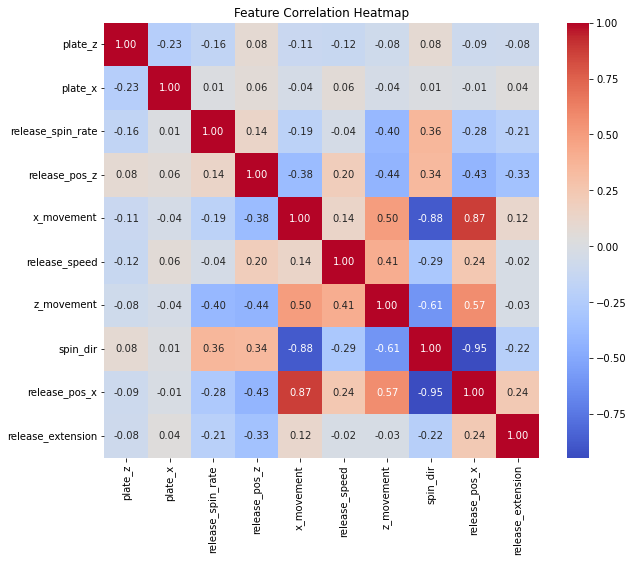

In [226]:
# Calculate the correlation matrix for the important columns
correlation_matrix = X[important_cols].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

### We can see from the above correlation heatmap that x_movement is highly correlated with both release_pos_x and spin_dir, since the random forest found that x_movement is more important than these other 2, we can choose to not include release_pos_x and spin_dir in our logistic model

### Logistic Regression with weights Cross Validation  using features selected by the random forest. 

In [227]:
important_cols_log = important_cols.copy()
important_cols_log.remove('release_pos_x')
important_cols_log.remove('spin_dir')

# Create a logistic regression model with weights and cross-validation
logistic_cv = LogisticRegressionCV(
    class_weight = {0: 1, 1: 10},      
    cv=5,        
)

In [228]:
X_encoded.isna()

,release_speed,x_movement,z_movement,release_spin_rate,spin_dir,release_pos_x,release_pos_z,release_extension,plate_x,plate_z,Pitcher_Throws_R,Previous_Pitch_Curveball,Previous_Pitch_Cutter,Previous_Pitch_Fastball,Previous_Pitch_First Pitch,Previous_Pitch_Slider,Pitch_Category_Behind,Pitch_Category_Full,Pitch_Category_Neutral,Outs_1.0,Outs_2.0
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2446,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2447,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2448,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [229]:
logistic_cv.fit(X_encoded_scaled[important_cols_log],y)

# Make predictions on the test set
y_pred_log = logistic_cv.predict(X_test_scaled[important_cols_log])
classification_report_str_log = classification_report(y_test, y_pred_log)

# 4. Evaluation

### For the purpose of this exercise, we want to know what features cause swings and misses in curveballs. For that reason, we want to prioritize precision. If our model classifies a pitch as a swing and miss pitch, we want to be sure that this pitch did result in a swing and miss. Then we can analyze the values of important features of this pitch to accomplish this task. Because of this, we prefer the Random Forest model for our final model which has a precision of 1.0 compared to 0.18 on the test data. The Random Forest model only predicted 1 pitches as swing and miss pitches, but given the imbalanced data, that is okay. 

In [230]:
print("\nClassification Report Logistic Regression:")
print(classification_report_str_log)


Classification Report Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.56      0.70       434
           1       0.18      0.75      0.29        56

    accuracy                           0.58       490
   macro avg       0.56      0.65      0.50       490
weighted avg       0.86      0.58      0.65       490



In [231]:
print("\nClassification Report Random Forest:")
print(classification_report_str_rf)


Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       434
           1       1.00      0.02      0.04        56

    accuracy                           0.89       490
   macro avg       0.94      0.51      0.49       490
weighted avg       0.90      0.89      0.84       490



In [232]:
np.sum(y_pred_RF)

1

# 5. Visualizations

In [233]:
rf_model.fit(X_encoded,y)

all_predictions = rf_model.predict_proba(X_encoded)[:, 1]

In [234]:
X_encoded.columns

Index(['release_speed', 'x_movement', 'z_movement', 'release_spin_rate',
       'spin_dir', 'release_pos_x', 'release_pos_z', 'release_extension',
       'plate_x', 'plate_z', 'Pitcher_Throws_R', 'Previous_Pitch_Curveball',
       'Previous_Pitch_Cutter', 'Previous_Pitch_Fastball',
       'Previous_Pitch_First Pitch', 'Previous_Pitch_Slider',
       'Pitch_Category_Behind', 'Pitch_Category_Full',
       'Pitch_Category_Neutral', 'Outs_1.0', 'Outs_2.0'],
      dtype='object')

### Partial Dependency Plots

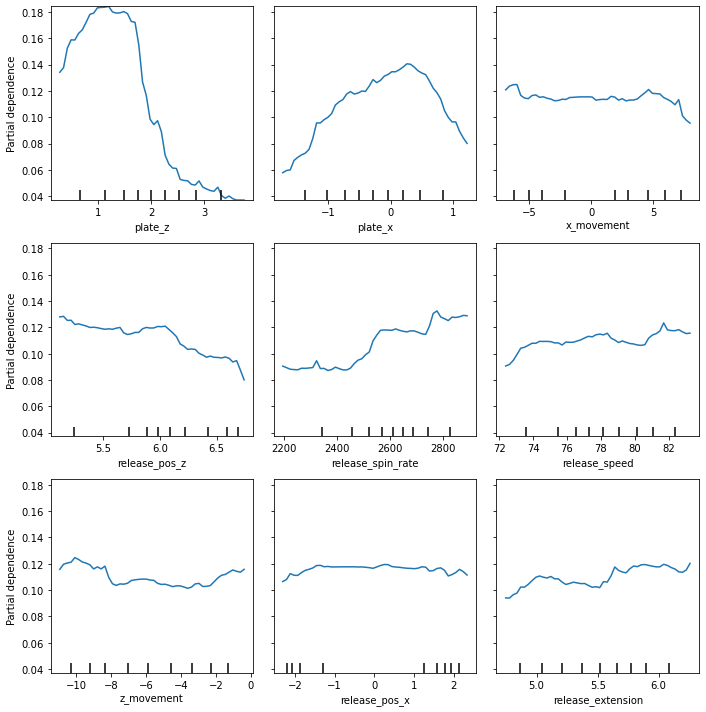

In [235]:
from sklearn.inspection import plot_partial_dependence

features = [9, 8, 1, 6,3,0,2,5,7]

# Plot partial dependence plots for each feature
fig, ax = plt.subplots(3,3,figsize=(10, 10))
plot_partial_dependence(rf_model, X_encoded,features , grid_resolution=50, ax=ax)
plt.tight_layout()
plt.show()

### Location Heatmap

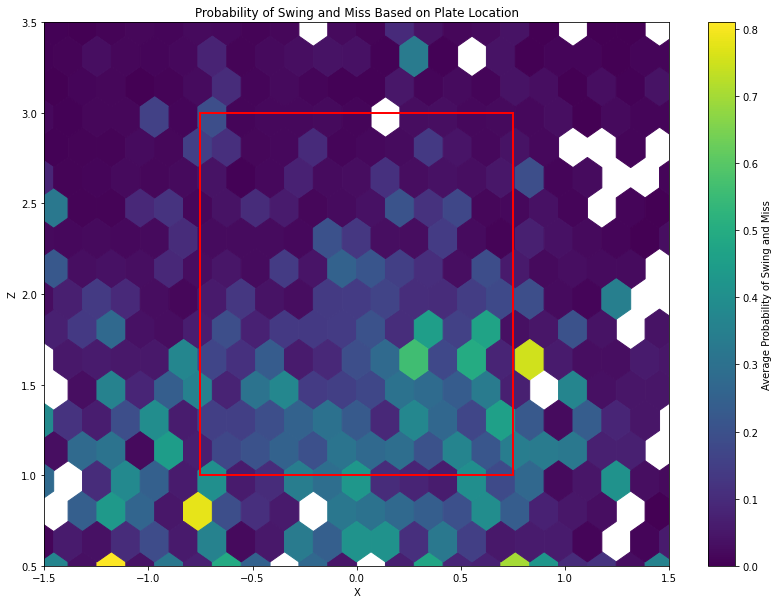

In [236]:
from matplotlib.patches import Rectangle

# Set the size of the figure
fig, ax = plt.subplots(figsize=(14, 10))

# Create a hexbin plot with a gradient color based on the average value of all_predictions
hb = ax.hexbin(X_encoded.plate_x, X_encoded.plate_z, C=all_predictions, cmap='viridis', gridsize=50)

# Add colorbar for reference
cbar = plt.colorbar(hb)
cbar.set_label('Average Probability of Swing and Miss')

# Set specific minimum and maximum values for the x and y axes
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0.5, 3.5)

# Add labels and title
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('Probability of Swing and Miss Based on Plate Location')

center_rectangle = Rectangle((-0.75, 1), 1.5, 2, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(center_rectangle)

# Show the plot
plt.show()